In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections
import pickle
import re
import math
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
train_pickle = pd.read_pickle('train_df.pickle')

In [3]:
train_pickle.reset_index(drop=True, inplace=True)

na_row = train_pickle[train_pickle.isna().any(axis=1)].index
na_col = train_pickle.columns[train_pickle.isna().any()]

print(len(na_row))
print(na_row)
display(train_pickle.loc[na_row])
train_df = train_pickle.drop(na_row)

train_df.reset_index(drop=True, inplace=True)

1
Int64Index([130152], dtype='int64')


,original_text,label,clean_text,tokens,lemmatized_text,num_words,num_characters,num_unique_words,ratio_unique_total_words,num_long_words,...,parse_tree_depth,num_clauses,num_noun_chunks,num_named_entities,avg_word_len,num_nsubj,punctuation_complexity,unique_tenses,unique_named_entity_types,avg_dependency_distance
130152,", ,",1,,[],,0,0,0,NaN,0,...,0,0,0,0,0.0,0,0,0,0,0.0


In [22]:
feature_list = train_df.iloc[:, 5:42].columns

filtered_feature_list = feature_list
filtered_feature_list = [item for item in filtered_feature_list if "num" not in item]
filtered_feature_list = [item for item in filtered_feature_list if "count" not in item]
filtered_feature_list = [item for item in filtered_feature_list if "len" not in item]
filtered_feature_list = [item for item in filtered_feature_list if "ratio" not in item]
filtered_feature_list = [item for item in filtered_feature_list if "unique" not in item]
filtered_feature_list = [item for item in filtered_feature_list if "dale_chall" not in item]
filtered_feature_list = [item for item in filtered_feature_list if "low" not in item]
print(filtered_feature_list)

['avg_syllables_per_word', 'lexical_diversity', 'only_punctuation', 'flesch_reading_ease_category', 'gunning_fog_category', 'smog_index_category', 'high_aoa', 'mean_concreteness', 'mean_subtlex_us_frequency', 'parse_tree_depth', 'punctuation_complexity', 'avg_dependency_distance']


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

filtered_X = train_df[filtered_feature_list]

param_grid = {
    'n_clusters': [2],
    'init': ['random', 'k-means++'],
    'n_init': [1, 10, 20],
    'algorithm': ['lloyd', 'elkan', 'auto', 'full']
}

results = []

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for algorithm in param_grid['algorithm']:
            model = KMeans(n_clusters=2, init=init, n_init=n_init, algorithm=algorithm, random_state=0)
            model.fit(filtered_X)
            predictions = model.predict(filtered_X)
            accuracy = accuracy_score(train_df['label'], predictions)
            results.append([2, init, n_init, algorithm, accuracy])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['n_clusters', 'init', 'n_init', 'algorithm', 'accuracy'])

    n_clusters       init  n_init algorithm  accuracy
0            2     random       1     elkan  0.474474
1            2     random       1      auto  0.474474
2            2     random       1      full  0.474474
3            2     random      10     elkan  0.525370
4            2     random      10      auto  0.525370
5            2     random      10      full  0.525370
6            2     random      20     elkan  0.474637
7            2     random      20      auto  0.474637
8            2     random      20      full  0.474637
9            2  k-means++       1     elkan  0.525521
10           2  k-means++       1      auto  0.525521
11           2  k-means++       1      full  0.525521
12           2  k-means++      10     elkan  0.474503
13           2  k-means++      10      auto  0.474503
14           2  k-means++      10      full  0.474503
15           2  k-means++      20     elkan  0.474637
16           2  k-means++      20      auto  0.474637
17           2  k-means++   

In [66]:
results_df

,n_clusters,init,n_init,algorithm,accuracy
0,2,random,1,elkan,0.474474
1,2,random,1,auto,0.474474
2,2,random,1,full,0.474474
3,2,random,10,elkan,0.525370
4,2,random,10,auto,0.525370
5,2,random,10,full,0.525370
6,2,random,20,elkan,0.474637
7,2,random,20,auto,0.474637
8,2,random,20,full,0.474637
9,2,k-means++,1,elkan,0.525521


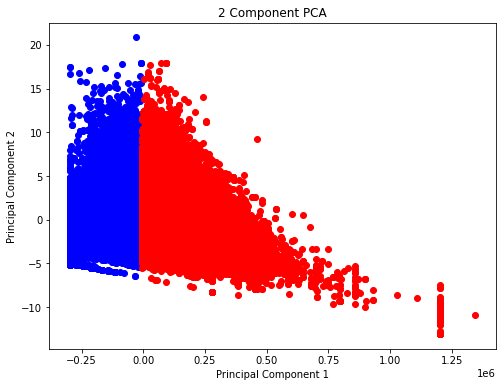

In [64]:
best_model = KMeans(n_clusters=2, init='k-means++', n_init=1, algorithm='auto', random_state=0)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(filtered_X)
principal_df = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])

# add a 'target' column to the principalDf
principal_df["target"] = best_model.fit_predict(filtered_X)

# plot
plt.figure(figsize=(8,6))
plt.scatter(principal_df.loc[principal_df["target"] == 0, 'principal component 1'], principal_df.loc[principal_df["target"] == 0, 'principal component 2'], color='blue')
plt.scatter(principal_df.loc[principal_df["target"] == 1, 'principal component 1'], principal_df.loc[principal_df["target"] == 1, 'principal component 2'], color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 Component PCA')
plt.show()

In [73]:
from sklearn.metrics import silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 4]
X_1 = train_df[filtered_feature_list]
scaler = StandardScaler()
std_X_1 = scaler.fit_transform(X_1)
y = train_df['label']

for n_clusters in tqdm(range_n_clusters):
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(std_X_1)

    
    silhouette_avg = silhouette_score(std_X_1, cluster_labels, sample_size=50000)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

 50%|█████     | 1/2 [00:42<00:42, 42.38s/it]

For n_clusters = 2 The average silhouette_score is : 0.20884810760463876


100%|██████████| 2/2 [01:26<00:00, 43.09s/it]

For n_clusters = 4 The average silhouette_score is : 0.22590379900229246
